# 🧩 Driver Segmentation Analysis

This notebook aims to segment Formula 1 drivers into distinct profiles based on their seasonal performance, experience, and age.

We will build a clustering model to group similar driver-season instances, using the following features:

- `age`: average driver age in the season
- `wins`: number of wins in the season
- `normalized_points`: total points adjusted for scoring system
- `normalized_points_per_race`: efficiency across the season
- `races_in_season`: number of races the driver participated in

The goal is to identify distinct categories of drivers such as:
- Dominant champions
- Consistent competitors
- Young emerging talents
- Occasional participants

Clustering is performed using **KMeans**, with evaluation based on **Silhouette Score** and PCA visualization.


In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from pathlib import Path
import pandas as pd

# 📂 Percorsi
RAW_DIR = Path("../../data/raw/rohanrao_formula-1-world-championship-1950-2020")
PROCESSED_PATH = Path("../../data/processed/points_per_driver_season.csv")

# 📥 Carica i dati
df = pd.read_csv(PROCESSED_PATH)
drivers = pd.read_csv(RAW_DIR / "drivers.csv")

In [30]:
# Filter: only seasons from 1970 onward and drivers with >= 12 races
df = df[(df["year"] >= 1970) & (df["races_in_season"] >= 12)]

# Drop rows with missing values
df = df.dropna(subset=["age", "wins", "normalized_points", "normalized_points_per_race", "races_in_season"])


In [31]:
# 🎯 Select features to cluster on
features = df[[
    "age",
    "wins",
    "normalized_points",
    "normalized_points_per_race",
    "races_in_season"
]].copy()


In [32]:
from sklearn.preprocessing import StandardScaler

# ⚖️ Standardize features (z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Optional: convert to DataFrame for inspection
X = pd.DataFrame(X_scaled, columns=features.columns, index=df.index)


In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 📊 Test K from 2 to 6
silhouette_scores = []
inertias = []
k_range = range(2, 7)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = model.fit_predict(X)
    
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    inertias.append(model.inertia_)
    print(f"k={k}: Silhouette Score = {score:.3f} | Inertia = {model.inertia_:.0f}")


k=2: Silhouette Score = 0.562 | Inertia = 5180
k=3: Silhouette Score = 0.458 | Inertia = 4351
k=4: Silhouette Score = 0.303 | Inertia = 3272
k=5: Silhouette Score = 0.304 | Inertia = 2994
k=6: Silhouette Score = 0.332 | Inertia = 2374


In [34]:
# 🧠 Fit KMeans with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
df["cluster"] = kmeans.fit_predict(X)

In [35]:
# 📋 Cluster profile summary
cluster_summary = df.groupby("cluster")[[
    "age",
    "wins",
    "normalized_points",
    "normalized_points_per_race",
    "races_in_season"
]].mean().round(2)

cluster_summary


,age,wins,normalized_points,normalized_points_per_race,races_in_season
cluster,,,,,
0,28.98,0.08,0.79,0.05,16.55
1,29.47,3.67,8.54,0.47,17.97


In [36]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 🎯 Reduce to 2D with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# 🔍 Check feature weights in PCA components
pca_weights = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=["PCA 1", "PCA 2"]
).T

pca_weights

,PCA 1,PCA 2
age,0.018498,0.756239
wins,0.532660,0.136051
normalized_points,0.582481,0.009558
normalized_points_per_race,0.578501,0.066357
races_in_season,0.204900,-0.636473


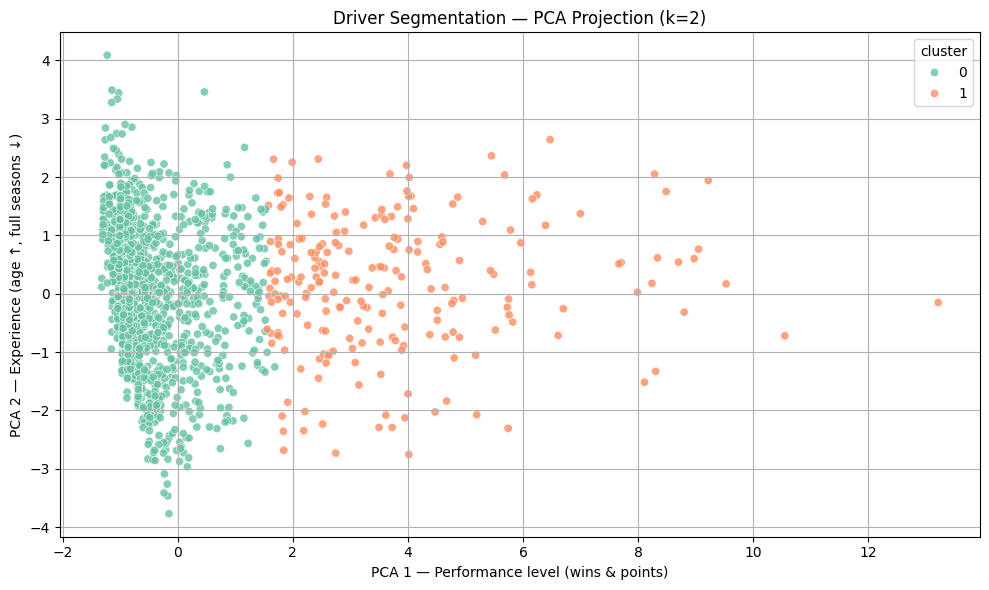

In [37]:
# Add to DataFrame
df["pca_1"] = pca_result[:, 0]
df["pca_2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="cluster", palette="Set2", alpha=0.8)

plt.title("Driver Segmentation — PCA Projection (k=2)")
plt.xlabel("PCA 1 — Performance level (wins & points)")
plt.ylabel("PCA 2 — Experience (age ↑, full seasons ↓)")

plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
# 🔢 Clustering con k=4
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init="auto")
df["cluster_4"] = kmeans_4.fit_predict(X)

In [39]:
# 📊 Medie per ciascun cluster
df.groupby("cluster_4")[[
    "age", "wins", "normalized_points", "normalized_points_per_race", "races_in_season"
]].mean().round(2)


,age,wins,normalized_points,normalized_points_per_race,races_in_season
cluster_4,,,,,
0,32.48,0.06,0.57,0.04,15.64
1,29.79,1.87,6.45,0.37,17.51
2,29.05,7.82,12.31,0.66,18.55
3,25.17,0.02,0.65,0.04,17.49


In [40]:
# 👥 Map cluster numbers to labels
cluster_labels = {
    0: "Experienced Runners",
    1: "Contenders",
    2: "Elite Performers",
    3: "Young Inexperienced"
}

df["profile_4"] = df["cluster_4"].map(cluster_labels)

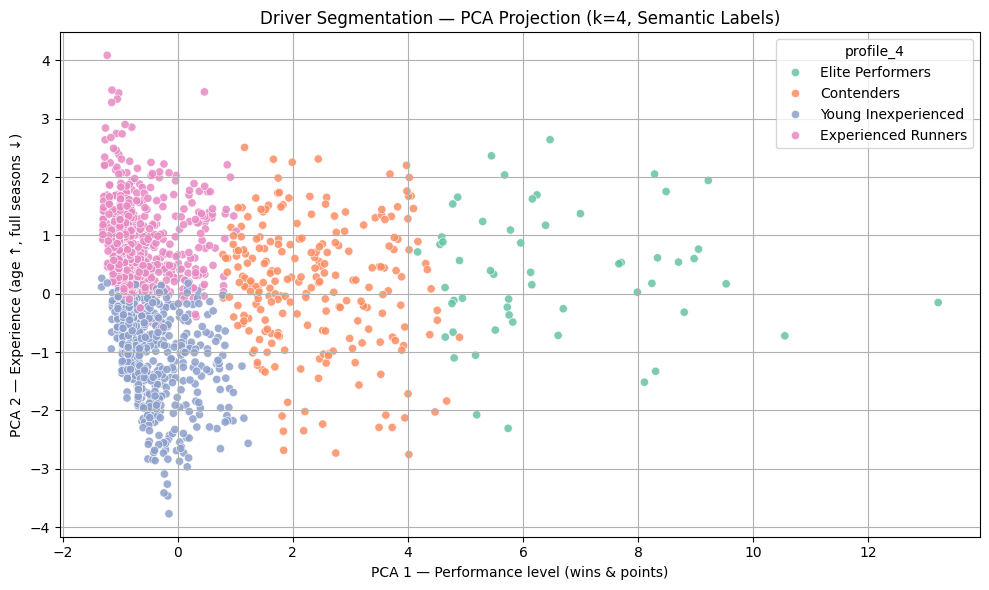

In [41]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="profile_4", palette="Set2", alpha=0.85)

plt.title("Driver Segmentation — PCA Projection (k=4, Semantic Labels)")
plt.xlabel("PCA 1 — Performance level (wins & points)")
plt.ylabel("PCA 2 — Experience (age ↑, full seasons ↓)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# 👤 Join con nomi piloti
df_named = df.merge(
    drivers[["driverId", "forename", "surname"]],
    on="driverId",
    how="left"
)

# 🧱 Crea colonna full name
df_named["driver_name"] = df_named["forename"] + " " + df_named["surname"]

In [44]:
# 📊 Top 5 drivers per profilo
top_by_profile = []

for profile, group in df_named.groupby("profile_4"):
    top5 = group.sort_values(by="normalized_points", ascending=False).head(5).copy()
    top5["profile"] = profile
    top_by_profile.append(top5[["profile", "driver_name", "year", "age", "wins", "normalized_points"]])

# 🔗 Combina i risultati
top_profiles = pd.concat(top_by_profile).sort_values("profile").reset_index(drop=True)

# 👁️ Visualizza in tabella
from IPython.display import display
display(top_profiles)

,profile,driver_name,year,age,wins,normalized_points
0,Contenders,Valtteri Bottas,2017,27.345654,3,12.200000
1,Contenders,Sergio Pérez,2022,31.931554,2,11.640000
2,Contenders,Charles Leclerc,2022,24.210815,3,11.640000
3,Contenders,Rubens Barrichello,2004,31.608487,2,11.400000
4,Contenders,Sebastian Vettel,2015,27.498973,3,11.120000
5,Elite Performers,Lewis Hamilton,2018,32.982888,11,16.320000
6,Elite Performers,Lewis Hamilton,2019,33.982204,11,16.520000
7,Elite Performers,Max Verstappen,2024,26.253251,9,15.960000
8,Elite Performers,Max Verstappen,2023,25.253936,19,21.200000
9,Elite Performers,Max Verstappen,2022,24.254620,15,17.320000


In [ ]:
from sklearn.cluster import KMeans

# 🎯 KMeans con k=5
kmeans_5 = KMeans(n_clusters=5, random_state=42, n_init="auto")
df["cluster_5"] = kmeans_5.fit_predict(X)

In [ ]:
df.groupby("cluster_5")[[
    "age", "wins", "normalized_points", "normalized_points_per_race", "races_in_season"
]].mean().round(2)

,age,wins,normalized_points,normalized_points_per_race,races_in_season
cluster_5,,,,,
0,32.48,0.05,0.54,0.03,15.66
1,30.64,2.13,5.37,0.34,16.03
2,29.87,8.56,12.58,0.68,18.33
3,25.18,0.02,0.64,0.04,17.48
4,27.84,1.57,8.58,0.43,20.20


In [54]:
cluster_5_labels = {
    0: "Experienced Runners",
    1: "Contenders",
    2: "Elite",
    3: "Young Inexperienced",
    4: "Young Contenders"
}

df["profile_5"] = df["cluster_5"].map(cluster_5_labels)


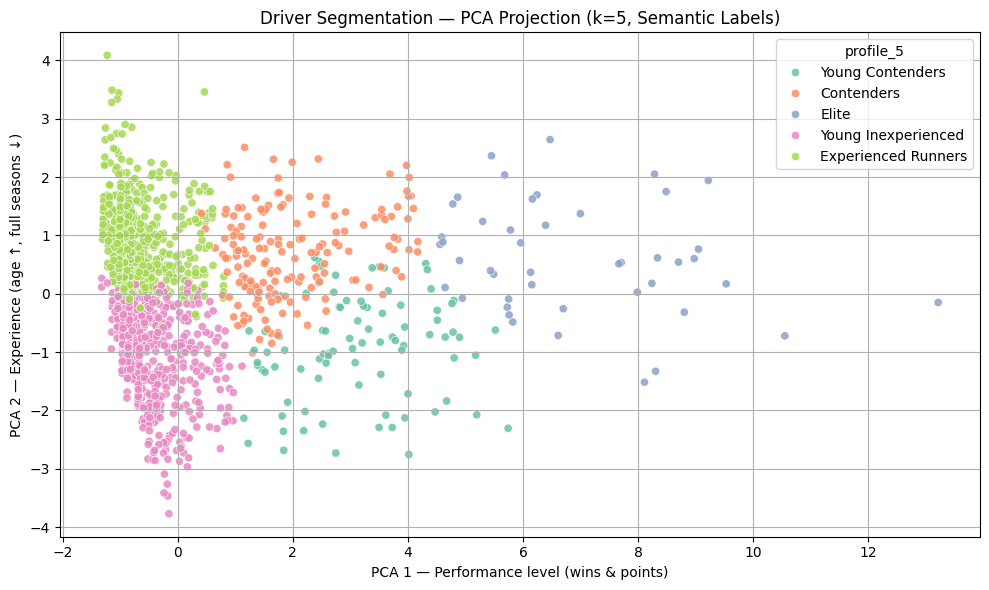

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="pca_1", y="pca_2", hue="profile_5", palette="Set2", alpha=0.85)

plt.title("Driver Segmentation — PCA Projection (k=5, Semantic Labels)")
plt.xlabel("PCA 1 — Performance level (wins & points)")
plt.ylabel("PCA 2 — Experience (age ↑, full seasons ↓)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [58]:
from pathlib import Path
import pandas as pd

# 📂 Percorsi
RAW_DIR = Path("../../data/raw/rohanrao_formula-1-world-championship-1950-2020")
drivers = pd.read_csv(RAW_DIR / "drivers.csv")

# 👤 Aggiunta nome completo
df_named = df.merge(
    drivers[["driverId", "forename", "surname"]],
    on="driverId",
    how="left"
)
df_named["driver_name"] = df_named["forename"] + " " + df_named["surname"]


In [59]:
# 📊 Top 5 per ciascun profilo 5
top_by_profile = []

for profile, group in df_named.groupby("profile_5"):
    top5 = group.sort_values(by="normalized_points", ascending=False).head(5).copy()
    top5["profile"] = profile
    top_by_profile.append(top5[["profile", "driver_name", "year", "age", "wins", "normalized_points"]])

# 🔗 Combina i risultati
top_profiles_5 = pd.concat(top_by_profile).sort_values("profile").reset_index(drop=True)

# 👁️ Visualizza
from IPython.display import display
display(top_profiles_5)


,profile,driver_name,year,age,wins,normalized_points
0,Contenders,Alain Prost,1989,33.853525,4,9.000000
1,Contenders,Mika Häkkinen,2000,31.258042,4,8.900000
2,Contenders,Nelson Piquet,1987,34.373717,3,8.444444
3,Contenders,Alain Prost,1985,29.853525,5,8.444444
4,Contenders,Alain Prost,1986,30.852841,4,8.222222
5,Elite,Max Verstappen,2023,25.253936,19,21.200000
6,Elite,Max Verstappen,2022,24.254620,15,17.320000
7,Elite,Lewis Hamilton,2019,33.982204,11,16.520000
8,Elite,Lewis Hamilton,2018,32.982888,11,16.320000
9,Elite,Max Verstappen,2024,26.253251,9,15.960000


In [60]:
# 📊 Conta quante stagioni per ogni profilo per ogni pilota
profile_counts = df_named.groupby(["driverId", "profile_5"]).size().unstack(fill_value=0)

In [61]:
# 🏁 Profilo principale: quello più frequente
profile_counts["main_profile_5"] = profile_counts.idxmax(axis=1)

In [62]:
# 👥 Merge con nomi dei piloti
profile_summary = profile_counts.merge(
    drivers[["driverId", "forename", "surname"]],
    on="driverId",
    how="left"
)

# 👤 Nome completo
profile_summary["driver_name"] = profile_summary["forename"] + " " + profile_summary["surname"]

# ➕ Aggiungi numero di stagioni
profile_summary["num_seasons"] = profile_counts.drop(columns="main_profile_5").sum(axis=1)


In [63]:
columns_to_display = ["driver_name", "main_profile_5", "num_seasons"] + profile_counts.columns[:-1].tolist()
profile_summary = profile_summary[columns_to_display].sort_values("num_seasons", ascending=False)

from IPython.display import display
display(profile_summary.head(15))

,driver_name,main_profile_5,num_seasons,Contenders,Elite,Experienced Runners,Young Contenders,Young Inexperienced
4,Heikki Kovalainen,Young Inexperienced,21.0,1,0,0,0,6
22,Ralf Schumacher,Young Inexperienced,19.0,4,0,2,0,5
30,Juan Pablo Montoya,Contenders,19.0,4,0,0,0,2
8,Robert Kubica,Young Inexperienced,19.0,0,0,2,2,3
18,Anthony Davidson,Young Inexperienced,18.0,0,0,0,0,4
1,Nick Heidfeld,Young Inexperienced,18.0,2,0,3,0,7
119,Fabrizio Barbazza,Experienced Runners,17.0,0,0,1,0,1
20,Giancarlo Fisichella,Young Inexperienced,16.0,2,0,5,0,7
15,Adrian Sutil,Young Inexperienced,15.0,0,0,0,0,7
110,Jean-Marc Gounon,Experienced Runners,15.0,0,0,2,0,0


In [64]:
profile_summary.to_csv("../../data/processed/driver_career_profiles.csv", index=False)

In [69]:
df_profiles = pd.read_csv("../../data/processed/driver_career_profiles.csv")

# 💾 Esporta in HTML
df_profiles.to_html("driver_career_profiles.html", index=False)

In [70]:
from IPython.display import HTML

HTML('<a href="driver_career_profiles.html" target="_blank">🔗 Open Career Profiles Table in Browser</a>')